In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.tsa.stattools as ts
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


In [32]:
#road
#df = pd.read_csv('C:/Users/dlwjd/school/datamining/samsung_week.csv')
#df = pd.read_csv('C:/Users/dlwjd/school/datamining/celltrion_week.csv')
df = pd.read_csv('C:/Users/dlwjd/school/datamining/sinpung_week.csv')

#set index to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] -= pd.Timedelta(weeks=1)   # 주식 주봉처럼 시작날로 보정
df.set_index(df['Date'], inplace=True)
df = df.drop('Date', 1)

#주가
start_date = '2017-07-03'
end_date = '2020-11-30'
#삼성 : 005930  셀트리온 : 068270  신풍 : 019170
#stock_week = pdr.get_data_yahoo('005930.ks', start_date, end_date, interval='w')
#stock_week = pdr.get_data_yahoo('068270.ks', start_date, end_date, interval='w')
stock_week = pdr.get_data_yahoo('019170.ks', start_date, end_date, interval='w')
#변동성
stock_week['Volatility'] = ((stock_week['High'] - stock_week['Low']) / stock_week['Low'])*100
stock_week = stock_week.loc[:,['Volume', 'Close','Volatility']]


#증감률
df = pd.concat([df, stock_week], axis=1)
df2 = df.loc[:, ['Post_num','Volume']]
df3 = df2.shift(1)
df4 = (df2/df3 -1) *100
df = pd.concat([df, df4], axis=1)
df = df.iloc[1:]  # 전 주를 크롤링안했음
df.columns = ['글 수', '거래량', '가격', '가격 변동성', '글 수 증감률', '거래량 증감률']
df.index = df.index.rename('날짜(주)')
df = df.reindex(columns=['글 수', '거래량', '글 수 증감률', '거래량 증감률', '가격', '가격 변동성'])
display(df.head())

,글 수,거래량,글 수 증감률,거래량 증감률,가격,가격 변동성
날짜(주),,,,,,
2017-07-09,20,441875,17.647059,16.119106,6120,5.333333
2017-07-16,11,289160,-45.000000,-34.560679,6220,3.966942
2017-07-23,22,387900,100.000000,34.147185,5820,8.808290
2017-07-30,6,241137,-72.727273,-37.835267,5950,6.914894
2017-08-06,3,437861,-50.000000,81.581839,5810,10.608696


C:\Users\dlwjd\Anaconda3\envs\python37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dlwjd\Anaconda3\envs\python37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


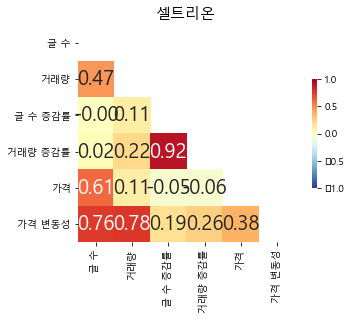

In [33]:
#상관분석

corr=df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cor_heatmap = sns.heatmap(corr, cbar = True, annot = True, mask=mask,annot_kws={'size' : 20}, 
                         fmt = '.2f', square = True, cbar_kws={"shrink": .5}, cmap = 'RdYlBu_r',
                         vmin = -1.0,vmax = 1)

plt.title('셀트리온', fontsize=15)
plt.show()


In [39]:
#공적분, granger 인과성
print("글 수 -> 가격 변동성")
score, pvalue, _ = ts.coint(df['글 수'],df['가격 변동성'])
print('Cointegration test p-value: ' + str(pvalue))
granger_test_result = ts.grangercausalitytests(df[['글 수',
                                                '가격 변동성']].values,maxlag=2)
print()
print("거래량 -> 변동성")
score, pvalue, _ = ts.coint(df['거래량'],df['가격 변동성'])
print('Cointegration test p-value: ' + str(pvalue))
granger_test_result = ts.grangercausalitytests(df[['거래량',
                                                '가격 변동성']].values, maxlag=2)

print()
print("가격 변동성 -> 글 수")
score, pvalue, _ = ts.coint(df['가격 변동성'], df['글 수'])
print('Cointegration test p-value: ' + str(pvalue))
granger_test_result = ts.grangercausalitytests(df[['가격 변동성',
                                                   '글 수']].values,maxlag=2)

print()
print("가격 변동성 -> 거래량")
score, pvalue, _ = ts.coint(df['가격 변동성'], df['거래량'])
print('Cointegration test p-value: ' + str(pvalue))
granger_test_result = ts.grangercausalitytests(df[['가격 변동성', 
                                                   '거래량']].values, maxlag=2)
                                                                                                                            

글 수 -> 가격 변동성
Cointegration test p-value: 0.01876634760428459

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2537 , p=0.0004  , df_denom=174, df_num=1
ssr based chi2 test:   chi2=13.4822 , p=0.0002  , df=1
likelihood ratio test: chi2=12.9934 , p=0.0003  , df=1
parameter F test:         F=13.2537 , p=0.0004  , df_denom=174, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7803  , p=0.0037  , df_denom=171, df_num=2
ssr based chi2 test:   chi2=11.8987 , p=0.0026  , df=2
likelihood ratio test: chi2=11.5138 , p=0.0032  , df=2
parameter F test:         F=5.7803  , p=0.0037  , df_denom=171, df_num=2

거래량 -> 변동성
Cointegration test p-value: 0.00019830017905753344

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7558  , p=0.0542  , df_denom=174, df_num=1
ssr based chi2 test:   chi2=3.8206  , p=0.0506  , df=1
likelihood ratio test: chi2=3.7799  , p=0.0519  , df=1
parameter F test:         F=3.7558  , p=0.

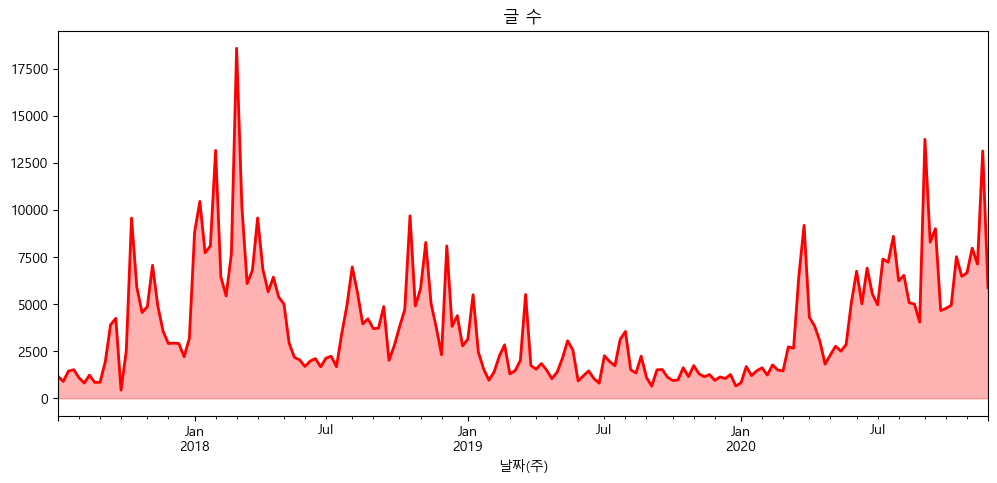

In [393]:
#sns.set_style("whitegrid")
#sns.reset_defaults()

#visualization
plt.figure(figsize=(12, 5))
ax = df['글 수'].plot(title = '글 수',color='red', lw=2)
ax.fill_between(df.index, 0, df['글 수'], color='red', alpha=.3)

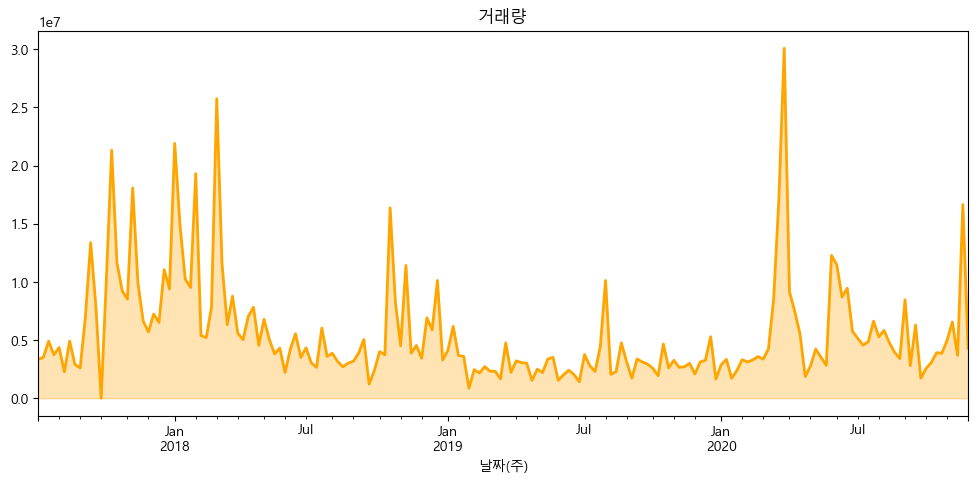

In [394]:
plt.figure(figsize=(12, 5))
ax = df['거래량'].plot(title = '거래량',color='orange', lw=2)
ax.fill_between(df.index, 0, df['거래량'], color='orange', alpha=.3)

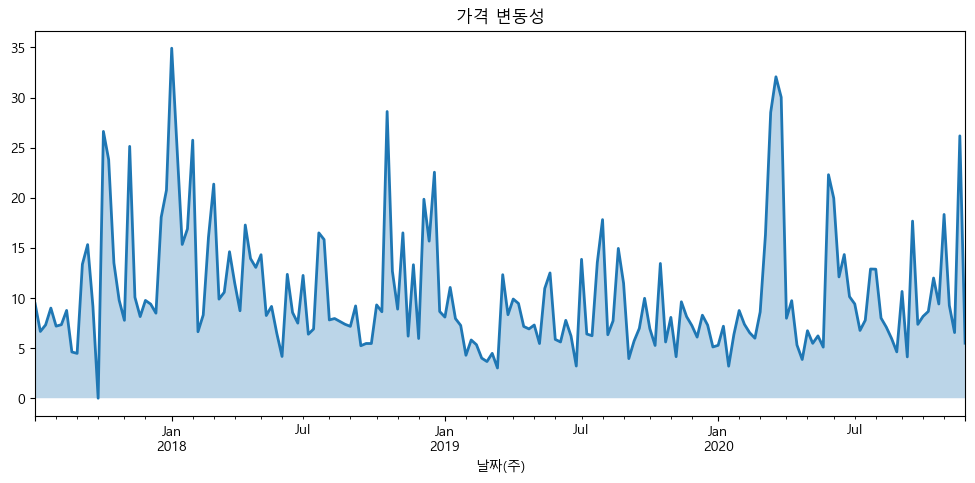

In [395]:
plt.figure(figsize=(12, 5))
ax = df['가격 변동성'].plot(title = '가격 변동성', lw=2)
ax.fill_between(df.index, 0, df['가격 변동성'], alpha=.3)

<AxesSubplot:title={'center':'가격'}, xlabel='날짜(주)'>

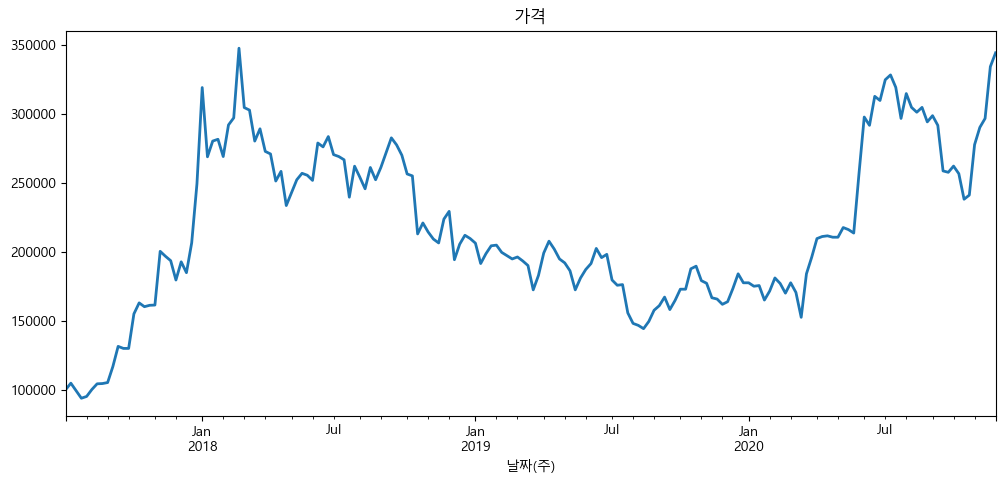

In [396]:
plt.figure(figsize=(12, 5))
df['가격'].plot(title = '가격', lw=2)
